In [1]:
# Síntese de Textura Alternativa usando OpenCV
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.metrics import pairwise_distances



# Síntese de Textura por Exemplo - Método Alternativo

Este notebook demonstra um método alternativo para síntese de textura baseada em exemplo utilizando OpenCV e scikit-learn. O método implementado utiliza a abordagem de "patch-based sampling", que consiste em:

1. Extrair pequenos patches da textura de exemplo
2. Encontrar patches semelhantes através de clustering
3. Sintetizar uma nova textura usando esses patches

Esta implementação é diferente do método existente em synthesis.py, fornecendo uma alternativa mais flexível para experimentação.

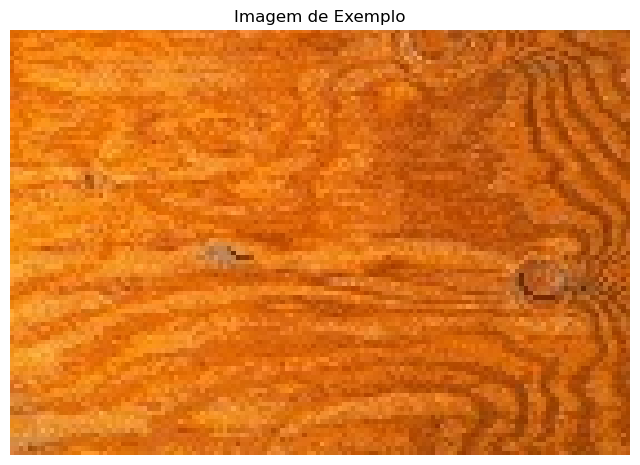

In [2]:
def load_and_display_image(image_path):
    """
    Carrega uma imagem e exibe utilizando matplotlib
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Erro: Não foi possível carregar a imagem: {image_path}")
        return None
    
    # Converter BGR para RGB para exibição correta
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Imagem de Exemplo')
    plt.show()
    
    return img

# Carregar uma imagem de exemplo
example_path = "../examples/wood.jpg"  # Altere para o caminho da sua imagem
example_image = load_and_display_image(example_path)

## Método de Síntese de Textura Baseado em Patches

O algoritmo implementado segue estas etapas:
1. Extração de patches: Dividimos a imagem de exemplo em pequenos patches sobrepostos
2. Agrupamento: Usamos K-Means para agrupar patches similares
3. Síntese: Construímos uma nova textura selecionando e mesclando patches
4. Avaliação: Comparamos a textura sintetizada com a original usando métricas

Tamanho da imagem: (96, 140, 3)
Número de patches extraídos: 35
Tamanho de cada patch: (32, 32, 3)


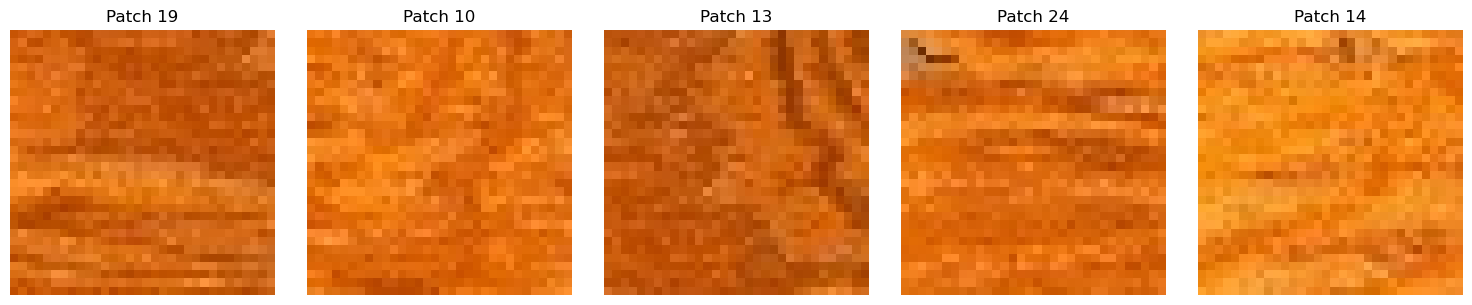

In [3]:
def extract_image_patches(image, patch_size, stride=None):
    """
    Extrai patches de uma imagem usando o tamanho e stride especificados
    
    Args:
        image: Imagem de entrada
        patch_size: Tamanho do patch (tuple: altura, largura)
        stride: Stride entre patches. Se None, usa metade do patch_size
    
    Returns:
        patches: Array de patches extraídos
        positions: Posições de onde os patches foram extraídos
    """
    if stride is None:
        stride = (patch_size[0] // 2, patch_size[1] // 2)
    
    if len(image.shape) == 3:
        h, w, c = image.shape
    else:
        h, w = image.shape
        c = 1
        image = image.reshape(h, w, c)
    
    patches = []
    positions = []
    
    # Extrair patches com stride
    for y in range(0, h - patch_size[0] + 1, stride[0]):
        for x in range(0, w - patch_size[1] + 1, stride[1]):
            patch = image[y:y+patch_size[0], x:x+patch_size[1], :]
            patches.append(patch)
            positions.append((y, x))
    
    return np.array(patches), positions

# Testar a função de extração de patches
if example_image is not None:
    patch_size = (32, 32)  # Tamanho do patch
    patches, positions = extract_image_patches(example_image, patch_size)
    
    print(f"Tamanho da imagem: {example_image.shape}")
    print(f"Número de patches extraídos: {len(patches)}")
    print(f"Tamanho de cada patch: {patches[0].shape}")
    
    # Exibir alguns patches de exemplo
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        idx = np.random.randint(0, len(patches))
        patch_rgb = cv2.cvtColor(patches[idx], cv2.COLOR_BGR2RGB)
        axes[i].imshow(patch_rgb)
        axes[i].set_title(f"Patch {idx}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\lucia\miniconda3\envs\lir\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\lucia\miniconda3\envs\lir\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\lucia\miniconda3\envs\lir\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\lucia\miniconda3\envs\lir\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\lucia\miniconda3\envs\lir\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 80: invalid continuation byte


Cluster 0: 1 patches
Cluster 1: 1 patches
Cluster 2: 9 patches
Cluster 3: 2 patches
Cluster 4: 6 patches
Cluster 5: 6 patches
Cluster 6: 9 patches
Cluster 7: 1 patches


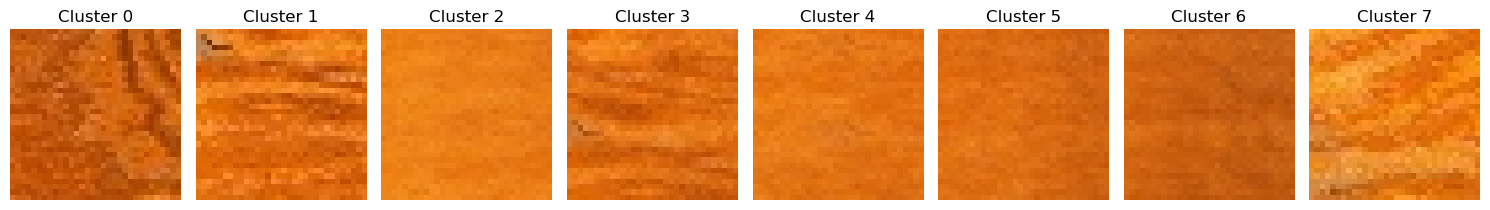

In [4]:
def cluster_patches(patches, n_clusters=10):
    """
    Agrupa patches similares usando K-means clustering
    
    Args:
        patches: Array de patches extraídos
        n_clusters: Número de clusters
    
    Returns:
        labels: Rótulos de cluster para cada patch
        centroids: Centroides de cada cluster
    """
    # Reshape patches para vetores
    n_patches, h, w, c = patches.shape
    patches_flat = patches.reshape(n_patches, -1)
    
    # Aplicar K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(patches_flat)
    centroids = kmeans.cluster_centers_.reshape(n_clusters, h, w, c)
    
    return labels, centroids

if example_image is not None and 'patches' in locals():
    # Agrupar os patches
    n_clusters = 8
    labels, centroids = cluster_patches(patches, n_clusters)
    
    # Contar patches em cada cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} patches")
    
    # Visualizar centroides dos clusters (representam texturas típicas)
    fig, axes = plt.subplots(1, n_clusters, figsize=(15, 3))
    for i in range(n_clusters):
        centroid_rgb = cv2.cvtColor(centroids[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        axes[i].imshow(centroid_rgb)
        axes[i].set_title(f"Cluster {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## Síntese da Nova Textura

Agora vamos implementar o algoritmo de síntese da textura. O processo consiste em:

1. Criar uma imagem de saída vazia com o tamanho desejado
2. Para cada posição na imagem de saída:
   - Encontrar patches similares na imagem de exemplo
   - Selecionar um patch aleatoriamente entre os similares
   - Aplicar mesclagem com sobreposição para evitar artefatos
3. Preencher a imagem de saída com os patches selecionados

In [9]:
def synthesize_texture(example_image, output_size, patch_size=(32, 32), overlap=0.5, n_clusters=10):
    """
    Sintetiza uma nova textura baseada na imagem de exemplo
    
    Args:
        example_image: Imagem de exemplo
        output_size: Tamanho da textura de saída (altura, largura)
        patch_size: Tamanho dos patches
        overlap: Fração de sobreposição entre patches adjacentes
        n_clusters: Número de clusters para agrupar patches similares
    
    Returns:
        output_texture: Textura sintetizada
    """
    # Extrair patches da imagem de exemplo
    stride = (int(patch_size[0] * (1-overlap)), int(patch_size[1] * (1-overlap)))
    patches, positions = extract_image_patches(example_image, patch_size, stride)
    
    # Agrupar patches
    labels, _ = cluster_patches(patches, n_clusters)
    
    # Calcular passo de síntese baseado na sobreposição
    synth_stride = (int(patch_size[0] * (1-overlap)), int(patch_size[1] * (1-overlap)))
    
    # Criar imagem de saída
    if len(example_image.shape) == 3:
        output_texture = np.zeros((output_size[0], output_size[1], example_image.shape[2]), dtype=np.float32)
    else:
        output_texture = np.zeros(output_size, dtype=np.float32)
    
    # Matriz de contagem para normalização
    weight_map = np.zeros(output_size, dtype=np.float32)
    
    # Criar janela de mesclagem (gradiente suave nas bordas para mesclagem)
    y_weight = np.cos(np.linspace(-np.pi/2, np.pi/2, patch_size[0])) * 0.5 + 0.5
    x_weight = np.cos(np.linspace(-np.pi/2, np.pi/2, patch_size[1])) * 0.5 + 0.5
    window = np.outer(y_weight, x_weight)
    
    # Para cada posição na imagem de saída
    for y in range(0, output_size[0] - patch_size[0] + 1, synth_stride[0]):
        for x in range(0, output_size[1] - patch_size[1] + 1, synth_stride[1]):
            # Selecionar cluster aleatório
            cluster_id = np.random.randint(0, n_clusters)
            
            # Encontrar patches deste cluster
            cluster_indices = np.where(labels == cluster_id)[0]
            
            if len(cluster_indices) > 0:
                # Escolher um patch aleatório do cluster
                idx = np.random.choice(cluster_indices)
                patch = patches[idx].astype(np.float32)
                
                # Aplicar mesclagem ponderada para evitar bordas visíveis
                if len(example_image.shape) == 3:
                    for c in range(patch.shape[2]):
                        # Corrigido: certificar que window tem a forma correta
                        output_texture[y:y+patch_size[0], x:x+patch_size[1], c] += patch[:, :, c] * window
                else:
                    output_texture[y:y+patch_size[0], x:x+patch_size[1]] += patch * window
                
                weight_map[y:y+patch_size[0], x:x+patch_size[1]] += window
    
    # Normalizar pela matriz de peso
    weight_map = np.maximum(weight_map, 1e-10)  # Evitar divisão por zero
    
    if len(example_image.shape) == 3:
        for c in range(output_texture.shape[2]):
            output_texture[:, :, c] /= weight_map
    else:
        output_texture /= weight_map
    
    # Converter para uint8
    output_texture = np.clip(output_texture, 0, 255).astype(np.uint8)
    
    return output_texture

# Função para exibir os resultados
def display_results(original, synthesized):
    """
    Exibe a imagem original e a sintetizada lado a lado
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # Converter para RGB para exibição correta
    if len(original.shape) == 3:
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        synthesized_rgb = cv2.cvtColor(synthesized, cv2.COLOR_BGR2RGB)
    else:
        original_rgb = original
        synthesized_rgb = synthesized
    
    axes[0].imshow(original_rgb)
    axes[0].set_title('Textura Original')
    axes[0].axis('off')
    
    axes[1].imshow(synthesized_rgb)
    axes[1].set_title('Textura Sintetizada')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Sintetizando textura...
Síntese concluída em 0.02 segundos.


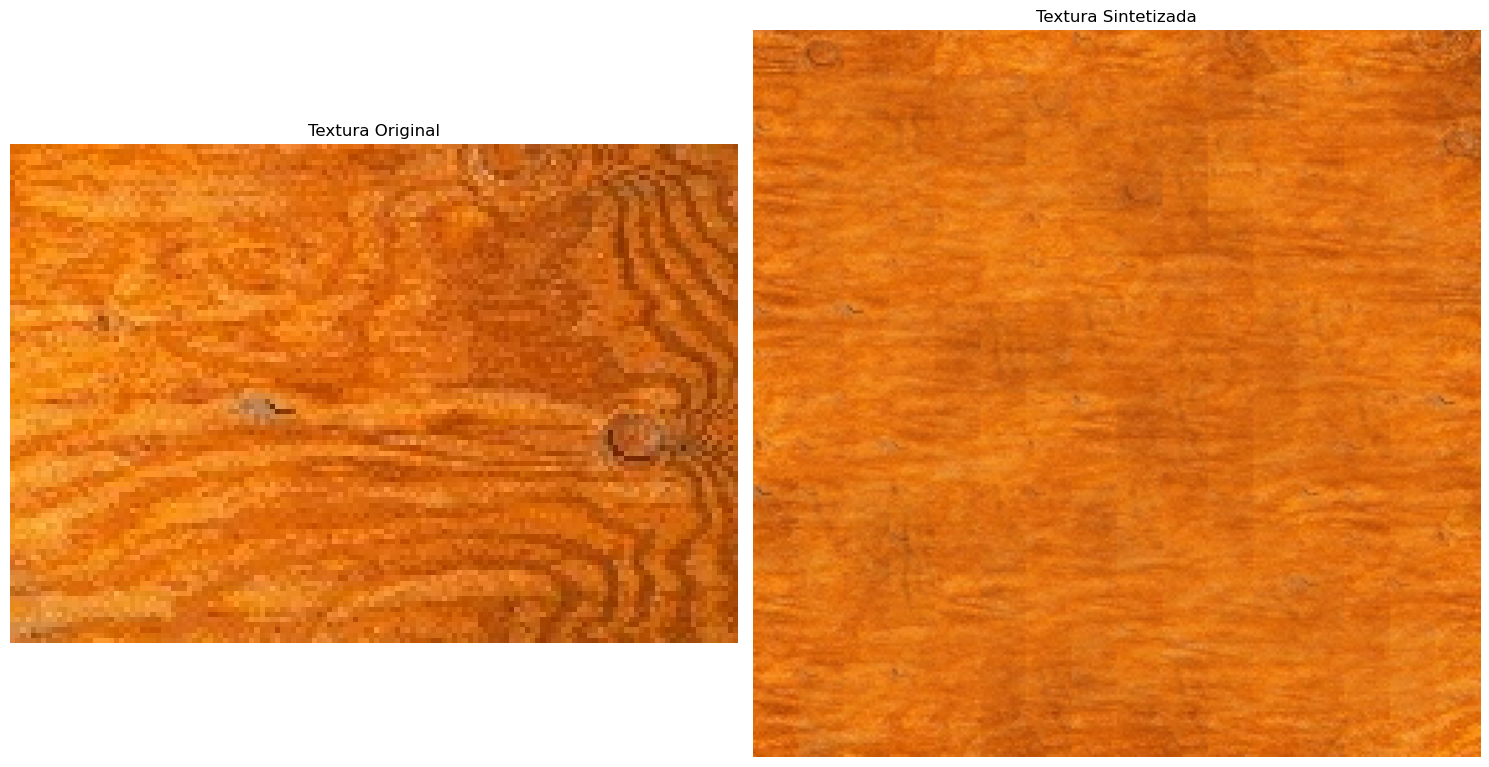

Textura salva em: ../result/synthetic_texture_a6d27506.jpg


In [10]:
# Sintentizar a textura
if example_image is not None:
    # Definir parâmetros
    patch_size = (32, 32)
    output_size = (256, 256)
    overlap = 0.5
    n_clusters = 12
    
    print("Sintetizando textura...")
    
    # Medir o tempo de execução
    import time
    start_time = time.time()
    
    # Sintetizar a nova textura
    synthesized_texture = synthesize_texture(
        example_image, 
        output_size, 
        patch_size=patch_size,
        overlap=overlap,
        n_clusters=n_clusters
    )
    
    elapsed_time = time.time() - start_time
    print(f"Síntese concluída em {elapsed_time:.2f} segundos.")
    
    # Exibir os resultados
    display_results(example_image, synthesized_texture)
    
    # Salvar a textura sintetizada
    import os
    output_dir = "../result"
    os.makedirs(output_dir, exist_ok=True)
    
    import uuid
    output_filename = f"{output_dir}/synthetic_texture_{str(uuid.uuid4())[:8]}.jpg"
    cv2.imwrite(output_filename, synthesized_texture)
    print(f"Textura salva em: {output_filename}")

## Método Alternativo usando scikit-image

A biblioteca scikit-image também oferece uma implementação para síntese de textura. Vamos comparar com o nosso método:

Sintetizando textura usando scikit-image...
Síntese concluída em 0.02 segundos.


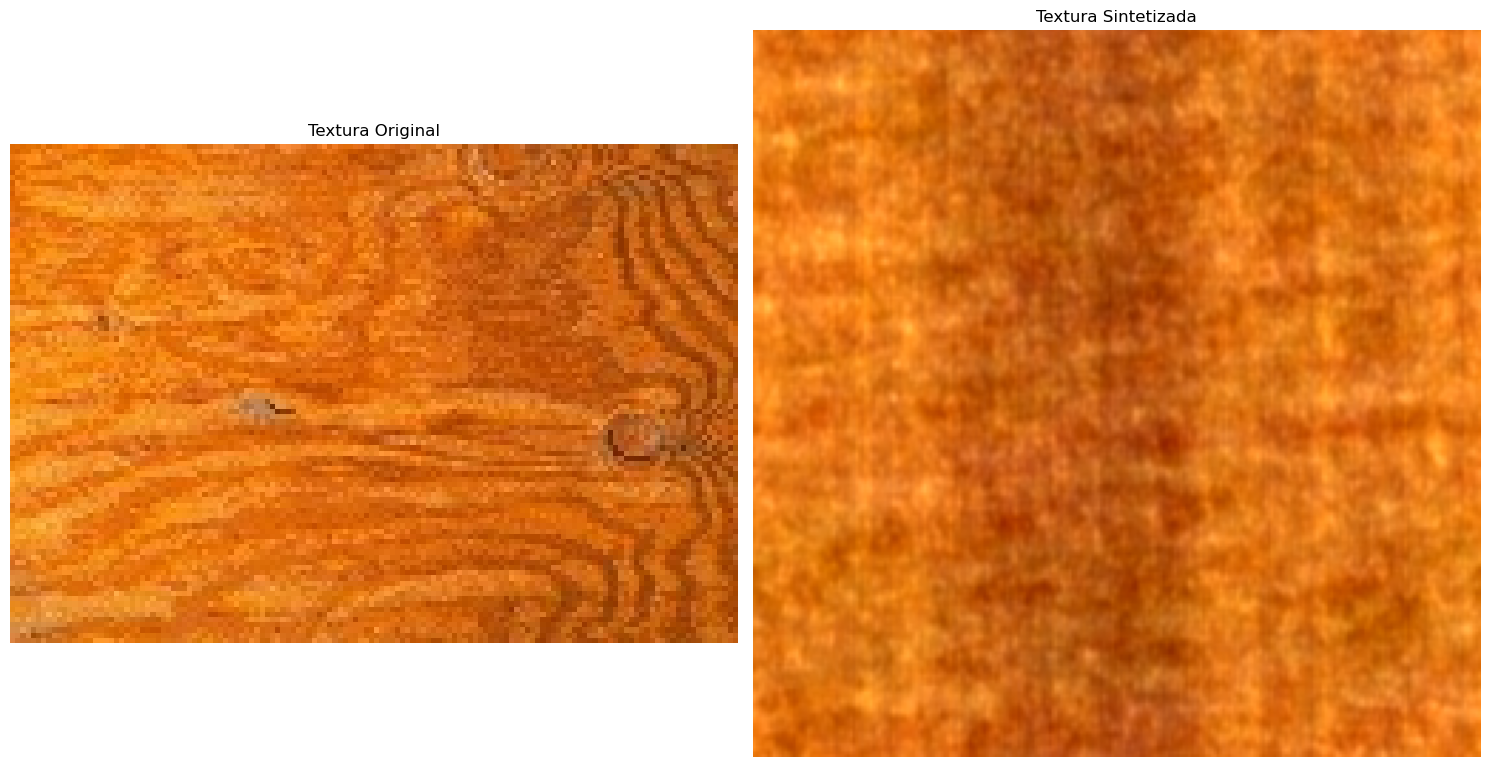

Textura salva em: ../result/skimage_texture_7cea83d9.jpg


In [13]:
try:
    # Importar bibliotecas necessárias
    from skimage.transform import resize
    from skimage.util import random_noise
    from skimage import img_as_ubyte, img_as_float

    def synthesize_texture_skimage(example_image, output_size):
        """
        Sintetiza textura usando o método de síntese por ruído + filtros da scikit-image
        
        Args:
            example_image: Imagem de exemplo
            output_size: Tamanho da textura de saída (altura, largura)
            
        Returns:
            output_texture: Textura sintetizada
        """
        # Converter para float [0, 1] para processamento
        if len(example_image.shape) == 3:
            # Converter BGR para RGB
            example_float = img_as_float(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))
        else:
            example_float = img_as_float(example_image)
            
        # Redimensionar para tamanho adequado se necessário
        if example_float.shape[0] < 64 or example_float.shape[1] < 64:
            example_float = resize(example_float, (max(64, example_float.shape[0]), 
                                                  max(64, example_float.shape[1])))
            
        # Criar ruído como base da textura
        noise = random_noise(np.zeros(output_size[:2]), mode='gaussian')
        
        # Aplicar transformada de Fourier na imagem de exemplo
        from scipy import fftpack
        
        # Redimensionar o ruído para ter o mesmo tamanho da imagem de exemplo
        # OU redimensionar a imagem exemplo para o tamanho de saída desejado
        example_resized = resize(example_float, output_size[:2])
        
        if len(example_float.shape) == 3:
            # Processar cada canal de cor separadamente
            result = np.zeros((output_size[0], output_size[1], 3))
            for i in range(3):
                # FFT da imagem de exemplo redimensionada
                example_fft = fftpack.fft2(example_resized[:,:,i])
                example_spectrum = np.abs(example_fft)
                
                # FFT do ruído
                noise_fft = fftpack.fft2(noise)
                
                # Usar a amplitude da imagem exemplo e fase do ruído
                combined = example_spectrum * np.exp(1j * np.angle(noise_fft))
                
                # Transformada inversa para obter a textura
                result[:,:,i] = np.real(fftpack.ifft2(combined))
        else:
            # Redimensionar a imagem para o tamanho de saída
            example_resized = resize(example_float, output_size)
            
            # FFT da imagem de exemplo redimensionada
            example_fft = fftpack.fft2(example_resized)
            example_spectrum = np.abs(example_fft)
            
            # FFT do ruído
            noise_fft = fftpack.fft2(noise)
            
            # Usar a amplitude da imagem exemplo e fase do ruído
            combined = example_spectrum * np.exp(1j * np.angle(noise_fft))
            
            # Transformada inversa para obter a textura
            result = np.real(fftpack.ifft2(combined))
            
        # Normalizar e converter para uint8
        result = np.clip(result, 0, 1)
        if len(result.shape) == 3:
            # Converter de volta para BGR para consistência
            result_uint8 = cv2.cvtColor(img_as_ubyte(result), cv2.COLOR_RGB2BGR)
        else:
            result_uint8 = img_as_ubyte(result)
            
        return result_uint8
    
    # Sintetizar textura com scikit-image
    if example_image is not None:
        print("Sintetizando textura usando scikit-image...")
        
        start_time = time.time()
        
        # Definir tamanho de saída
        output_size = (256, 256)
        
        # Sintetizar textura
        skimage_texture = synthesize_texture_skimage(example_image, output_size)
        
        elapsed_time = time.time() - start_time
        print(f"Síntese concluída em {elapsed_time:.2f} segundos.")
        
        # Exibir resultados
        display_results(example_image, skimage_texture)
        
        # Salvar textura
        output_filename = f"../result/skimage_texture_{str(uuid.uuid4())[:8]}.jpg"
        cv2.imwrite(output_filename, skimage_texture)
        print(f"Textura salva em: {output_filename}")
except ImportError as e:
    print(f"Não foi possível importar as bibliotecas necessárias: {e}")
    print("Certifique-se de que scikit-image e scipy estão instalados: pip install scikit-image scipy")

## Comparação e Avaliação de Resultados

Vamos comparar os dois métodos de síntese de textura implementados:

1. **Método baseado em patches**: Utiliza técnicas de recorte e colagem de patches da imagem original, com mesclagem nas sobreposições para evitar descontinuidades. É mais fiel à estrutura da textura original, preservando detalhes locais.

2. **Método baseado em FFT**: Utiliza transformadas de Fourier para capturar as características espectrais da textura, combinando-as com ruído para criar variabilidade. É mais eficiente, mas pode perder alguns detalhes estruturais.

Para avaliar qual método funciona melhor, podemos considerar:
- Fidelidade à textura original
- Ausência de artefatos ou descontinuidades
- Tempo de processamento
- Aplicabilidade a diferentes tipos de textura


Comparando métricas de qualidade:

Método baseado em patches:
MSE: 581.5177827380952
SSIM: 0.40554542732340576
LBP: 0.04668204140372853

Método baseado em FFT:
MSE: 891.5595982142858
SSIM: 0.4232930409736031
LBP: 0.13589866414955937


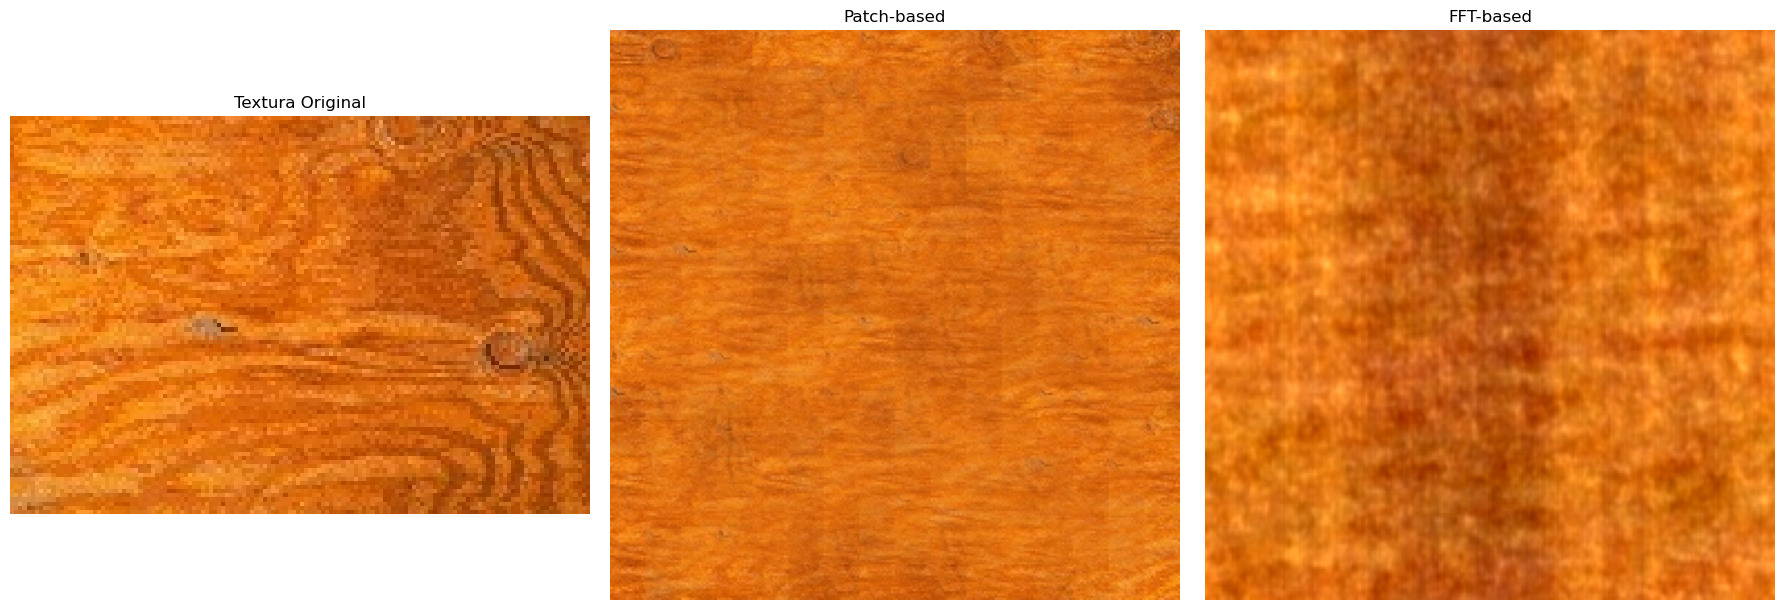

In [15]:
# Função para calcular métricas de qualidade
def calculate_quality_metrics(original, synthesized):
    """
    Calcula métricas de qualidade entre a textura original e a sintetizada
    """
    import sys
    sys.path.append('..')
    
    try:
        from metrics import mse, dssim, lbp_tile_distance
        
        # Converter para escala de cinza se necessário
        if len(original.shape) == 3:
            original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        else:
            original_gray = original
            
        if len(synthesized.shape) == 3:
            synthesized_gray = cv2.cvtColor(synthesized, cv2.COLOR_BGR2GRAY)
        else:
            synthesized_gray = synthesized
        
        # Redimensionar se os tamanhos forem diferentes
        if original_gray.shape != synthesized_gray.shape:
            synthesized_gray = cv2.resize(synthesized_gray, 
                                         (original_gray.shape[1], original_gray.shape[0]))
        
        # Calcular métricas
        mse_value = mse(original_gray, synthesized_gray)
        ssim_value = dssim(original_gray, synthesized_gray)
        
        try:
            lbp_value = lbp_tile_distance(original_gray, synthesized_gray)
        except Exception as e:
            print(f"Erro ao calcular LBP: {e}")
            lbp_value = None
        
        return {
            'MSE': mse_value,
            'SSIM': ssim_value,
            'LBP': lbp_value
        }
    except ImportError as e:
        print(f"Erro ao importar métricas: {e}")
        return None
    except Exception as e:
        print(f"Erro ao calcular métricas: {e}")
        return None

# Compare as métricas se as texturas foram geradas
if 'synthesized_texture' in locals() and 'skimage_texture' in locals():
    print("\nComparando métricas de qualidade:")
    print("\nMétodo baseado em patches:")
    patch_metrics = calculate_quality_metrics(example_image, synthesized_texture)
    if patch_metrics:
        for metric, value in patch_metrics.items():
            print(f"{metric}: {value}")
    
    print("\nMétodo baseado em FFT:")
    fft_metrics = calculate_quality_metrics(example_image, skimage_texture)
    if fft_metrics:
        for metric, value in fft_metrics.items():
            print(f"{metric}: {value}")
            
    # Exibir as três imagens lado a lado
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Converter para RGB para exibição correta
    example_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)
    patch_rgb = cv2.cvtColor(synthesized_texture, cv2.COLOR_BGR2RGB)
    fft_rgb = cv2.cvtColor(skimage_texture, cv2.COLOR_BGR2RGB)
    
    axes[0].imshow(example_rgb)
    axes[0].set_title('Textura Original')
    axes[0].axis('off')
    
    axes[1].imshow(patch_rgb)
    axes[1].set_title('Patch-based')
    axes[1].axis('off')
    
    axes[2].imshow(fft_rgb)
    axes[2].set_title('FFT-based')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Conclusão e Possíveis Melhorias

Neste notebook, implementamos dois métodos alternativos para síntese de textura baseada em exemplos:

1. **Método baseado em patches**: Reconstrói a textura usando pequenos recortes da imagem original.
2. **Método baseado em FFT**: Utiliza características espectrais da textura original.

### Possíveis melhorias:

1. **Preservação de estruturas globais**: Adicionar análise de estruturas em múltiplas escalas para preservar tanto detalhes locais quanto padrões globais.

2. **Patches de tamanho variável**: Implementar seleção adaptativa do tamanho dos patches baseada na complexidade local da textura.

3. **Texturas estilizadas**: Combinar características de múltiplas texturas para criar estilos mistos.

4. **Otimização de desempenho**: Implementar algoritmos mais eficientes para seleção de patches ou uso de CUDA para aceleração por GPU.

5. **Síntese controlada**: Permitir controle do usuário sobre regiões específicas da textura.

Para explorar mais sobre síntese de textura, considere também outras abordagens como:
- Redes neurais generativas (GANs)
- Modelos baseados em estatísticas de Markov
- Métodos baseados em wavelets